In [1]:
from cuml.cluster import KMeans
import numpy as np
from sklearn.datasets import fetch_openml
#from keras.datasets import mnist
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import cudf
import pickle

2024-06-28 15:33:17.449381: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-28 15:33:17.471986: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.astype(np.float32)
y = mnist.target.astype(int)

#X_cudf = cudf.DataFrame.from_pandas(pd.DataFrame(X))
print(X.shape)

(70000, 784)


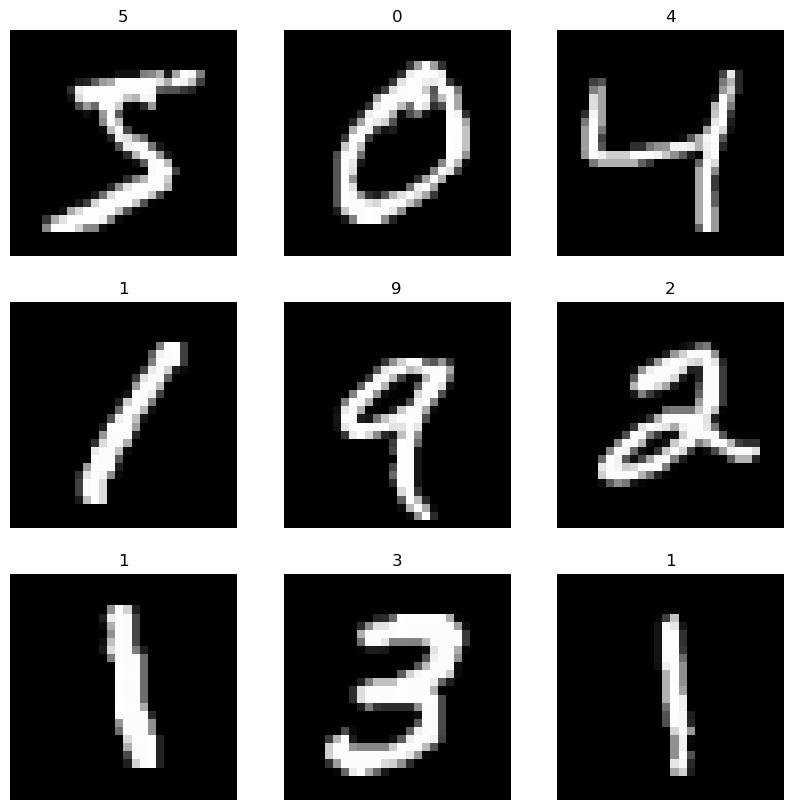

In [3]:
X_numpy = X.values
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for row in range(3):
    for col in range(3):
        image = X_numpy[3*row + col].reshape(28,28)
        axes[row][col].imshow(image, cmap='gray')
        axes[row][col].set_title(f'{y[3*row + col]}')
        axes[row][col].axis('off')
plt.show()

In [5]:
X_reshape = X.values.reshape(-1, 28, 28)
X_reshape = np.expand_dims(X_reshape, -1)
X_reshape.shape

(70000, 28, 28, 1)

In [8]:
def extract_patches(images, patch_size):
    patches = tf.image.extract_patches(images=images,
                                        sizes=[1, patch_size, patch_size, 1],
                                        strides=[1,1,1,1],
                                        rates=[1,1,1,1],
                                        padding='VALID')
    return patches
def extract_patches_batch(images, batch_size=256, patch_size=5):
    dataset = tf.data.Dataset.from_tensor_slices(images)
    dataset = dataset.batch(batch_size)
    patches_list = []
    for batch in dataset:
        patches = extract_patches(batch, patch_size)
        patches_list.append(patches)
    return tf.concat(patches_list, axis=0)

X_patches = extract_patches_batch(X_reshape)

2024-06-28 15:34:09.320883: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-28 15:34:09.322842: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-28 15:34:09.322861: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-28 15:34:09.326334: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-28 15:34:09.326352: I external/local_xla/xla/stream_executor

In [9]:
print(X_patches.shape)
def reshape_patches(patches):
    num_patches = patches.shape[0] * patches.shape[1] * patches.shape[2]
    patches = tf.reshape(patches, [num_patches, patches.shape[3]])
    return patches

flat_patches = reshape_patches(X_patches)
print(flat_patches.shape)

(70000, 24, 24, 25)
(40320000, 25)


In [30]:
X_cudf = cudf.DataFrame.from_records(flat_patches.numpy())

In [65]:
k = 10000

kmeans = KMeans(n_clusters=k)
kmeans.fit(X_cudf)

labels = kmeans.labels_

In [66]:
# SAVE MODEL
with open('kmeans_mnist_k10000.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

In [2]:
# LOAD MODEL
with open("kmeans_mnist_k10000.pkl", "rb") as f:
    model = pickle.load(f)

In [3]:
label_data = model.labels_.to_numpy()
centroids = model.cluster_centers_.to_pandas().values

print(type(label_data), len(label_data))

<class 'numpy.ndarray'> 40320000


In [6]:
def isolate_cluster(label, labels, data):
    cluster_data = []
    for i in range(len(labels)):
        if labels[i] == label:
            cluster_data.append((data[i], i))
    return cluster_data

In [15]:
cluster_data = isolate_cluster(2, label_data, flat_patches)

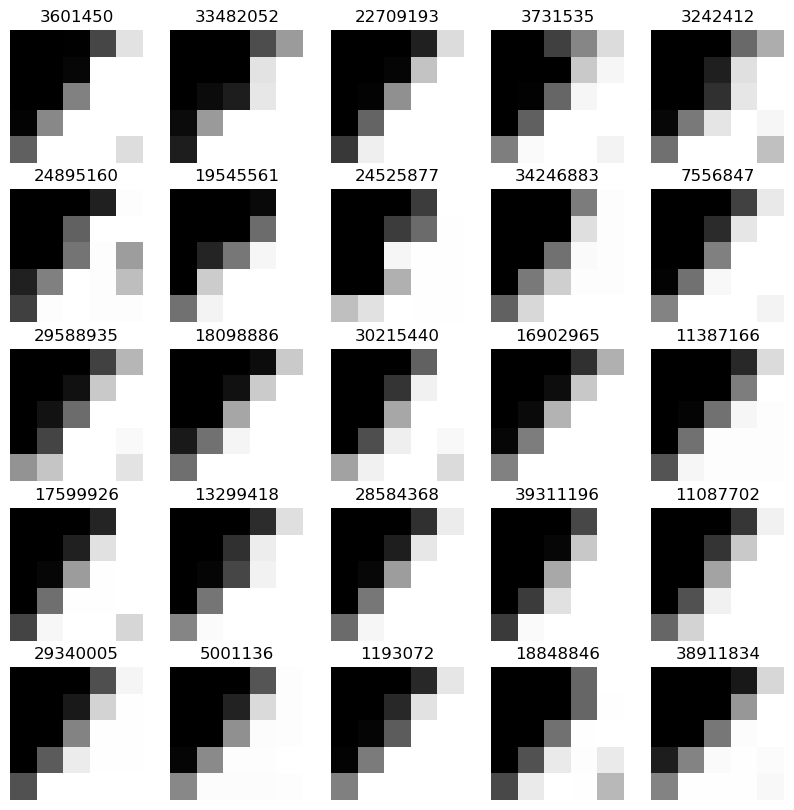

In [20]:
import random as rand

X_numpy = X.values
n = 5
fig, axes = plt.subplots(n, n, figsize=(10, 10))

for row in range(n):
    for col in range(n):
        pick = rand.choice(cluster_data)
        image = pick[0].numpy().reshape(5,5)
        axes[row][col].imshow(image, cmap='gray')
        axes[row][col].set_title(f'{pick[1]}')
        axes[row][col].axis('off')
plt.show()

nothing that interesting

In [ ]:
sample_patch = X_cudf.iloc[0]
type(sample_patch.to_numpy())

In [ ]:
# analysis: reconstruct centroid patch

def reconstruct_patch(patch, centroids):
    closest_centroid_idx = np.argmin(np.linalg.norm(centroids - patch, axis=1))
    return centroids[closest_centroid_idx]

sample_patch = X_cudf.iloc[0].to_numpy()
reconstructed_patch = reconstruct_patch(sample_patch, centroids)
print("original patch:")
print(sample_patch.reshape(5,5))
print("reconstructed patch:")
print(reconstructed_patch.reshape(5,5))

In [ ]:
x_l1 = []
y_l1 = []
for i in range(len(ynp)):
    if (ynp[i] == 1):
        x_l1.append(xnp[i])
        y_l1.append(ynp[i])
plt.scatter(xnp[:,0], xnp[:,1], c=labels, s=1, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title("K-means Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()